In [ ]:
#@title Imports
import logging
import random
from copy import copy

import random
import platform
from collections import Counter
from collections import namedtuple
#from gx_utils import *

In [ ]:
#@title Problem instances generator

def problem(N, seed=None):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [ ]:
#@title Some Functions for Preprocessing
#from traitlets.traitlets import Callable
import itertools

def remove_duplicates(list_):
  list_ = list(k for k,_ in itertools.groupby(list_))

  return list_

def sort_by(list_: list, key: Callable = None):
  list_.sort(key=key)
  return list_
  
def preproc(problem, rem_dup=False, sort=False, f:Callable = None):
  problem= sort_by(problem, key=f)
  problem= remove_duplicates(problem)

  #Make problem a list of sets, each inner list is now a set
  problem= list( set(problem[i]) for i in range(0,len(problem)))
  return problem



In [ ]:
#@title Problem init & PreProcessing

N = 500

prob_raw = problem(N, seed=42)
prob = preproc(prob_raw, sort=True, f=lambda x: -len(x))


#For each index of the main list problme, we link a set composed by the numbers the set covers
coverage_table = {}  #Something like {2: {1,3,4,8}}

for i, set_ith in enumerate(prob):
    coverage_table[i] = set_ith

prob_dim = len(prob)

NULL_SET_INDEX = prob_dim

#the last index is a null set, which stands for "No list taken"
coverage_table[NULL_SET_INDEX] = set()

prob.append(set())
prob[NULL_SET_INDEX]

#Update the problem dim after inserting the last element for the NULL SET
prob_dim = len(prob)


In [ ]:
#@title Class & Function Definitions for GA
from math import log

DEAFULT_GENOME_LENGHT = 11
#A CRITICAL PARAMETER
#used to define a maximum of lists taken as a solution
#Small values can lead to unacceptable solutions, while Big 
#values lead to a huge amount of possibilities for the individuals 
#and then to a really slow converge towards a minimum
GENOME_LENGTH = DEAFULT_GENOME_LENGHT

#function used to sort the inds, and selecting the "best" part of them
sorting_key= lambda x: (x.fitness[0])

#"Class" definition:
# genome and fitness attributes are both implemented as list, in order to
# access them and mutate them internally, in respect of tuple Immutability
Individual = namedtuple("Individual", ["genome", "fitness"])

def covered_by(genome) -> bool:
    "compute the coverage for a given genome"

    coverage = set()
    for index in genome:
        coverage |= prob[index]
        if coverage == set(range(0,N)):
            return True
    return False

#@TODO: Try more efficient or smart FF
#You can change this to try different fitness function (FF)
def fitness_function(genome):
    """
    Compute the fitness value for a given genome.

    Returns the count of integers present in the ind's genome

    If the genome leads to an unacceptable solution, its value will be MIN= -1000_000
    """

    MIN = -1000_000
    numbers = 0

    if covered_by(genome):
        
        for index in genome:  
            numbers = numbers + len(coverage_table[index])
        return -numbers

    return MIN

def evaluate(ind: Individual):
    """
    This function is mainly used as a wrap function, to let us change only the FF and leave the rest
    of the code untouched, using 'evaluate'. It also helps for readability
    """

    new_fitness_score = fitness_function(ind.genome)

    #Check to se if the ind has already an evaluation or not
    if len(ind.fitness) > 0:
        ind.fitness.pop()
    ind.fitness.append(new_fitness_score)

def mutate(ind: Individual, prob=0.1):
    """
    With a given probability 'prob' it mutates the given ind
    """

    # Due to the implementation of the NULL SET this function is
    # a bit more complex than it should be; we want that the NULL SET
    # may be added again even if it's already present in the genome.
    # The same thing is instead unacceptable for other genes (non-null lists)
    if random.random() < prob:
        k = random.randint(0, prob_dim-1)

        #If k is NULL_SET_INDEX it can be repeated in the genome
        if k == NULL_SET_INDEX:
            #Select a random gene
            j = random.randint(0, GENOME_LENGTH-1)

            #And change it
            ind.genome.pop(j)
            ind.genome.append(k)
        #If k is not NULL_SET_INDEX it cannot be repeated
        else:

            #So we check its presence in the genome...
            if k not in ind.genome:
                     #Select a random gene
                    j = random.randint(0, GENOME_LENGTH-1)

                    #And change it
                    ind.genome.pop(j)
                    ind.genome.append(k)

def random_new_individual():
  """
  This function create a random Individual object.
  """

  genome = list()

  local_prob = prob.copy()

  for _ in range(0, GENOME_LENGTH):

      index_pool= list(range(0,len(local_prob)))
      index_pool.append(NULL_SET_INDEX)
      #Extract a random list
      j = random.choice(index_pool)

      if j == NULL_SET_INDEX:
          #No pop required
          set_ith = set()
      else:
        index_pool.remove(j)
        set_ith = local_prob.pop(j)

      #Add it to the genome and to the coverage set
      genome.append(j)

  ind = Individual(genome, list())
  evaluate(ind)
  return ind

def mate(i1: Individual, i2: Individual, prob_mut=0.1) -> Individual:
  """
  Take two inds, randomly cut their genome and then create a new ind with 
  the genome create by the union of the two parts, properly
  """


  #cut_index = random.randint(0,len_genome)

  cut_index = random.randint( int( GENOME_LENGTH/3), int(2*GENOME_LENGTH/3) )
  new_genome = []
  new_genome[0:cut_index] = i1.genome[0:cut_index]
  new_genome[cut_index:] = i2.genome[cut_index:]
  ind = Individual(new_genome, [])
  mutate(ind, prob_mut)

  return ind


In [ ]:
#@title Offspring Generation Function
def generate_offspring_from(population: list,
                            PERCENTAGE_SELECTED=10, 
                            DIM_MAX_OFFSPRING=10_000, 
                            PROB_MUT= 0.1):
  """
  Generates a new list of inds (INDIS), starting from given 'population'.

  The main idea is to:
  1) select a specific part of the population given a p percentage, as the 'top';
  2) save these top INDIS (added in the offspring during the matin);
  3) let these top INDIS have a mating session at random couple (then extracted), 
     where their direct offspring genome is obtained as a part of the genome of 
     parent 1 and the other part from parent 2. 
  4) the 'child' is then mutated and added to the offspring list, together with both its parents
    NB: parents are extracted from the top_pop list, and added to the offspring

  RECAP:
  The population will be composed by the top p% of the population, and by their offspring, obtained through
  a sort of Recombination/crossover followed by a mutation

  @TODO: Try re-inserting the parents and have N random mating session at couple of even triplet or more 
        (I know it's kinda cringe...)

  @param: population Is the starting point for this function, the list of INDIS
  used to generate the new offspring (OFF).

  @param: PERCENTAGE_SELECTED Used to select the percentage of the population considered 
  "the best".    
  DEFAULT: 10

  @param: DIM_MAX_OFFSPRING Used to set a Maximum for the dimension of the offspring and avoid
  divergence/explosion of the general population.   
  DEAFULT: 10_000

  @param: PROB_MUT Probability to mutate. It is used to give the 'mutate()' method the probability
  to mutate a gene or not. It must be given as a number in the range [0,1).  
  DEFAULT: 0.1  (10%)

  """

  #Sort by: Coverage, Number of used numbers, Number of used lists
  #Crucial to cut the top p%
  population.sort(key=sorting_key, reverse=True)

  #get the index corresponding to the p%
  index = int( PERCENTAGE_SELECTED/100* len(population))

  #divide the population
  top_pop = population[0:index].copy()

  #May be useful for future implementations
  #bot_pop = population[index:]

  offspring = []

  #Mating Session loop
  while len(top_pop) >= 2:
    #Randomly select 2 indis and extract them
    i = random.randint(0, len(top_pop)-1)
    i1 = top_pop.pop(i)
    j = random.randint(0, len(top_pop)-1)
    i2 = top_pop.pop(j)

    #Mate them and obtain the child, mutate it and evaluate
    child = mate(i1, i2)
    mutate(child, PROB_MUT)
    evaluate(child)

    #Add everyone to the offspring
    offspring.append(i1)
    offspring.append(i2)
    offspring.append(child)

  #Sort crucial for potential Dim Max limit
  offspring.sort(key=sorting_key, reverse=True)

  if len(offspring) > DIM_MAX_OFFSPRING:
    return offspring[0:DIM_MAX_OFFSPRING]
  return offspring


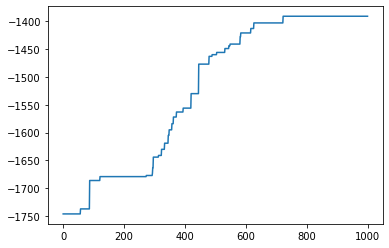

Individual(genome=[1287, 309, 1775, 154, 48, 682, 1284, 1809, 1794, 1804, 1188], fitness=[-1391])


In [ ]:
#@title Population Creation

#SETTING
GENOME_LENGTH = 11
DIM_POP = 2000
DIM_MAX_OFFSPRING= 1600
PERCENTAGE_SELECTED =75 #%
NUM_GEN = 1000
PROB_MUT = 0.7 #0.87 can be too high

#Create an array of Individual istances, each already evaluate
population = [random_new_individual() for _ in range(0, DIM_POP)]
population.sort(key=sorting_key, reverse=True)

#Plot variables init
best_for_gen = [-100000]
gens = range(0,NUM_GEN)
extinted = False

for gen in range(0, NUM_GEN):

  offspring=generate_offspring_from(population,
                                      PERCENTAGE_SELECTED=PERCENTAGE_SELECTED, 
                                      PROB_MUT = PROB_MUT, 
                                      DIM_MAX_OFFSPRING=DIM_MAX_OFFSPRING)
  
  if len(offspring) == 0:
      print(f"Population extinted at gen: {gen-1} with best: {population[0].fitness_score}")
      extinted = True
      break

  population = offspring

  best_score = population[0].fitness
  best_for_gen.append(best_score)

if not extinted:
    import matplotlib.pyplot as plt

    plt.plot(range(0,len(best_for_gen)-1), best_for_gen[1:])
    plt.show()
    print(population[0])


In [ ]:
print(population[0])
print( covered_by((population[0].genome)))